In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/drive')
import os
# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/My Drive/2023kd")

/bin/bash: line 1: google-drive-ocamlfuse: command not found
Mounted at /content/drive


In [ ]:
!pip install torchviz

In [ ]:
!pip install tsai

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchviz import make_dot

from fastcore.test import test_eq
from fastcore.basics import first
from fastai.data.external import untar_data, URLs
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import Categorify, FillMissing
from fastai.data.transforms import Normalize

from tsai.all import *
from tsai.models.GatedTabTransformer import GatedTabTransformer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

In [40]:
data = pd.read_csv('mobilegt-unifeaturedata-oversampler-30w-extendf.csv')

In [27]:
data = pd.read_csv('mobile-all-smote.csv')
#mobilegt-unifeaturedata-oversampler-30w-extendf.csv

In [41]:
data = data.rename(columns={'35':'label'})

In [ ]:
data

In [42]:
x=data.iloc[:,:-1]
x.drop(x.columns[0], axis=1, inplace=True)
y=data.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,stratify=y,random_state=40,test_size=0.3)
y_test = list(y_test)

In [ ]:
x,y

In [ ]:
heat_map_features = data
plt.figure(figsize=(15,12.5))
sns.heatmap(round(heat_map_features.corr(),1),annot=True,cmap='Blues',linewidth=0.9)
plt.show()

In [47]:
data.label = data.label.astype(str)
dls=TabularDataLoaders.from_df(data, path=".", y_names="label",
    cat_names = ['0', '1','2','3','4','5','6','7','8','9',
                 '10','11','12','13','14','15','16','17','18',
                 '19','20','21','22','23','24',
                 '25','26','27','28','29','30',
                 '31','32','33','34'],
    procs = [Categorify, FillMissing, Normalize])

In [ ]:
dls.c

In [46]:
my_array = np.array(y_train)
x_categ = torch.tensor(my_array)
x_categ = x_categ.view(1,len(y_train))
x_categ = x_categ.int()

In [49]:
x_categ.size(),x_categ

(torch.Size([1, 214300]),
 tensor([[7, 5, 3,  ..., 9, 3, 4]], dtype=torch.int32))

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from fastai.callback.all import *
from sklearn.metrics import precision_score, recall_score, f1_score
from fastai.metrics import *
from sklearn.metrics import precision_score, f1_score
def PrecisionMacro(*args, **kwargs):
    return AccumMetric(precision_score, dim_argmax=-1, average='macro', *args, **kwargs)

def RecallMacro(*args, **kwargs):
    return AccumMetric(recall_score, dim_argmax=-1, average='macro', *args, **kwargs)

def F1ScoreMacro(*args, **kwargs):
    return AccumMetric(f1_score, dim_argmax=-1, average='macro', *args, **kwargs)

model = GatedTabTransformer(dls.classes,dls.cont_names,dls.c,mlp_d_model=32,mlp_d_ffn=64,mlp_layers=4)
learn = Learner(dls,model,cbs=ShowGraphCallback(),loss_func=CrossEntropyLossFlat(),metrics=[accuracy, PrecisionMacro(), RecallMacro(), F1ScoreMacro()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.188139,0.185367,0.965212,0.965359,0.965415,0.965332,09:36
1,0.141754,0.200829,0.960688,0.960892,0.961131,0.960915,09:40
2,0.047888,0.293392,0.924724,0.925549,0.937498,0.924476,09:40


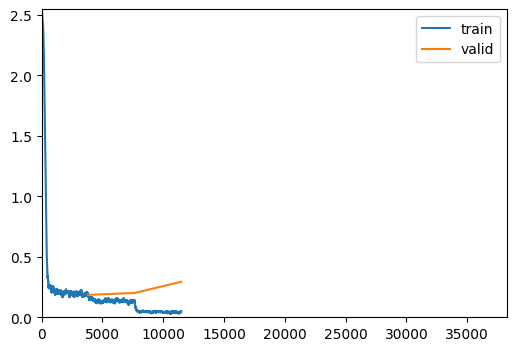

In [ ]:
learn.fit_one_cycle(10,1e-3)#
learn.save('Tabtrans_3-3')#

Mobilenetv3

In [ ]:
from fastai.vision.all import *
import torchvision.models as models
from tsai.all import *
from fastai.learner import Learner
from fastai.metrics import accuracy, F1Score, Precision, Recall

mobilenetv3 = models.mobilenet_v3_large(pretrained=True)  # 根据需要选择预训练或自定义版本
mobilenetv3.classifier[3] = nn.Linear(in_features=mobilenetv3.classifier[3].in_features, out_features=dls.c)  # 调整最后一层以匹配你的分类任务

# 使用tsai的Learner
learn = Learner(dls,
                mobilenetv3,
                metrics=[accuracy, F1Score(average='macro'), Precision(average='macro'), Recall(average='macro')],
                cbs=ShowGraphCallback(),
                loss_func=CrossEntropyLossFlat())

# 训练模型
learn.fit_one_cycle(100, 1e-3)


<bound method Learner.get_preds of <fastai.learner.Learner object at 0x7fcaadcf8af0>>